In [80]:
!pip install optuna

In [81]:
pip install ydata-profiling

In [82]:
# import packages

import pandas as pd
import datetime
import numpy as np
import shap
import time
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.inspection import partial_dependence

from contextlib import contextmanager


from ydata_profiling import ProfileReport
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [83]:


# Read train and test data
df_sales_train = pd.read_csv('/content/train.csv')
df_sales_test = pd.read_csv('/content/test.csv')

df_sales_train['split'] = 'train'
df_sales_test['split'] = 'test'
df_sales_test['Item_Outlet_Sales'] = 0


df_all=pd.concat([df_sales_train,df_sales_test])
display(df_all.tail())
# df_sales_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split
5676,FDB58,10.5,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,0.0,test
5677,FDD47,7.6,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,0.0,test
5678,NCO17,10.0,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,0.0,test
5679,FDJ26,15.3,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,0.0,test
5680,FDU37,9.5,Regular,0.104720,Canned,79.7960,OUT045,2002,NaN,Tier 2,Supermarket Type1,0.0,test


#EDA

In [84]:
# EDA

profile = ProfileReport(df_sales_train)
profile.to_file("bigmart_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:00<00:00, 42.18it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Cleaning  and Feature Engineering


In [85]:


# Item_Fat Content standardization
df_all["Item_Fat_Content"] = df_all["Item_Fat_Content"].str.strip().str.lower().str.replace(' ', '')

df_all["Item_Fat_Content"] = df_all["Item_Fat_Content"].replace({
    "lf": "low fat",
    "reg": "regular"
})

In [86]:
# Imputing Iem weight with mean weight

mean_item_weight = df_all.groupby('Item_Identifier')['Item_Weight'].mean()


df_all['Item_Weight'] = df_all['Item_Weight'].fillna(df_all['Item_Identifier'].map(mean_item_weight))

print(f"Remaining NaN values in 'Item_Weight' after imputation: {df_all['Item_Weight'].isnull().sum()}")
display(df_all.head())

Remaining NaN values in 'Item_Weight' after imputation: 0


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [87]:
df_sales_train['Item_Weight'].isnull().sum()

np.int64(1463)

In [88]:
# Group statistics at outlet level

sales_and_outlet_stats = df_all.groupby(['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type','Outlet_Identifier','Outlet_Establishment_Year'], dropna=False).agg(
    total_item_sales=('Item_Outlet_Sales', 'sum'),
    distinct_outlets=('Outlet_Identifier', 'nunique'),
    distinct_item=('Item_Identifier', 'nunique'),
).reset_index()
display(sales_and_outlet_stats)

,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Outlet_Establishment_Year,total_item_sales,distinct_outlets,distinct_item
0,High,Tier 3,Supermarket Type1,OUT013,1987,2.142664e+06,1,1553
1,Medium,Tier 1,Supermarket Type1,OUT049,1999,2.183970e+06,1,1550
2,Medium,Tier 3,Supermarket Type2,OUT018,2009,1.851823e+06,1,1546
3,Medium,Tier 3,Supermarket Type3,OUT027,1985,3.453926e+06,1,1559
4,Small,Tier 1,Grocery Store,OUT019,1985,1.796941e+05,1,880
5,Small,Tier 1,Supermarket Type1,OUT046,1997,2.118395e+06,1,1550
6,Small,Tier 2,Supermarket Type1,OUT035,2004,2.268123e+06,1,1550
7,NaN,Tier 2,Supermarket Type1,OUT017,2007,2.167465e+06,1,1543
8,NaN,Tier 2,Supermarket Type1,OUT045,2002,2.036725e+06,1,1548
9,NaN,Tier 3,Grocery Store,OUT010,1998,1.883402e+05,1,925


In [89]:
# imputing outlet size

df_all['Outlet_Size']=df_all['Outlet_Size'].fillna('Small')

In [90]:
# Imputing item visibility with mean visibility per item

mean_visibility_by_item_type = df_all[df_all['Item_Visibility'] != 0].groupby('Item_Type')['Item_Visibility'].mean()

df_all['Item_Visibility_masked'] = df_all['Item_Visibility'].copy()

zero_visibility_mask = df_all['Item_Visibility_masked'] == 0

df_all.loc[zero_visibility_mask, 'Item_Visibility_masked'] = df_all.loc[zero_visibility_mask, 'Item_Type'].map(mean_visibility_by_item_type)

print(f"Number of 0 values in 'Item_Visibility_masked' after imputation: {(df_all['Item_Visibility_masked'] == 0).sum()}")
display(df_all.head())

Number of 0 values in 'Item_Visibility_masked' after imputation: 0


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186


In [91]:
# calculating outlet_age variable

df_all['Current_Year'] = datetime.datetime.now().year
df_all['Outlet_Age'] = df_all['Current_Year'] - df_all['Outlet_Establishment_Year']

In [92]:
# calculating outlet average sales

train_outlet_avg_sales = df_all[df_all['split'] == 'train'].groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean()
df_all['Outlet_Average_Sales'] = df_all['Outlet_Identifier'].map(train_outlet_avg_sales)
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256


In [93]:
(df_all['Outlet_Average_Sales'] == 0).sum()

np.int64(0)

In [94]:
# extracting item category

df_all['item_category'] = df_all['Item_Identifier'].str.slice(0, 2)
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635,FD
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739,DR
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635,FD
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662,FD
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256,NC


In [95]:
# calculating item count per outlet

outlet_item_count = df_all.groupby('Outlet_Identifier')['Item_Identifier'].nunique().reset_index()
outlet_item_count.rename(columns={'Item_Identifier': 'Outlet_Item_Count'}, inplace=True)
df_all = pd.merge(df_all, outlet_item_count, on='Outlet_Identifier', how='left')
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635,FD,1550
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739,DR,1546
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635,FD,1550
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662,FD,925
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256,NC,1553


In [96]:

# calculating average sales per item category per outlet

item_cat_avg_sales_per_outlet = df_all[df_all['split'] == 'train'].groupby(['Outlet_Identifier', 'item_category'])['Item_Outlet_Sales'].mean().reset_index()
item_cat_avg_sales_per_outlet = item_cat_avg_sales_per_outlet.rename(columns={'Item_Outlet_Sales': 'Item_cat_Avg_Sales_Per_Outlet'})
df_all = pd.merge(df_all, item_cat_avg_sales_per_outlet, on=['Outlet_Identifier', 'item_category'], how='left')
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635,FD,1550,2337.653479
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739,DR,1546,1907.604188
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635,FD,1550,2337.653479
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662,FD,925,334.778691
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256,NC,1553,2235.667627


In [97]:
# calculating visibility ratio

df_all['Item_Visibility_Mean'] = df_all.groupby('Item_Identifier')['Item_Visibility'].transform('mean')
df_all['Visibility_Ratio'] = df_all['Item_Visibility'] / df_all['Item_Visibility_Mean']
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,train,0.016047,2026,27,2348.354635,FD,1550,2337.653479,0.017235,0.931078
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,train,0.019278,2026,17,1995.498739,DR,1546,1907.604188,0.020653,0.933420
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,train,0.016760,2026,27,2348.354635,FD,1550,2337.653479,0.017457,0.960069
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,train,0.073305,2026,28,339.351662,FD,925,334.778691,0.017834,0.000000
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,train,0.063186,2026,39,2298.995256,NC,1553,2235.667627,0.009780,0.000000


In [98]:
# grouping item type

df_all['Item_Type_cleaned'] = df_all['Item_Type'].str.strip().str.lower().str.replace(' ', '')

def item_type_grouper(item_type):
    if item_type in [
        'fruitsandvegetables', 'snackfoods', 'household', 'frozenfoods',
        'dairy', 'canned', 'bakinggoods', 'healthandhygiene', 'softdrinks', 'meat'
    ]:
        return item_type
    else:
        return 'others'

df_all['item_type_grouped'] = df_all['Item_Type_cleaned'].apply(item_type_grouper)
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio,Item_Type_cleaned,item_type_grouped
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,2026,27,2348.354635,FD,1550,2337.653479,0.017235,0.931078,dairy,dairy
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,2026,17,1995.498739,DR,1546,1907.604188,0.020653,0.933420,softdrinks,softdrinks
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,2026,27,2348.354635,FD,1550,2337.653479,0.017457,0.960069,meat,meat
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,2026,28,339.351662,FD,925,334.778691,0.017834,0.000000,fruitsandvegetables,fruitsandvegetables
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,2026,39,2298.995256,NC,1553,2235.667627,0.009780,0.000000,household,household


In [99]:
df_all['Outlet_Type_cleaned'] = df_all['Outlet_Type'].str.strip().str.lower().str.replace(' ', '')

In [100]:
df_all['Outlet_Location_Type_cleaned'] = df_all['Outlet_Location_Type'].str.strip().str.lower().str.replace(' ', '')

In [101]:
# item price bucket created

df_all['item_price_bucket'] = pd.qcut(df_all['Item_MRP'], q=4, labels=['Low', 'Med', 'High', 'Premium'])

item_price_map = {'Low': 1, 'Med': 2, 'High': 3, 'Premium': 4}
df_all['item_price_bucket'] = df_all['item_price_bucket'].map(item_price_map)

display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio,Item_Type_cleaned,item_type_grouped,Outlet_Type_cleaned,Outlet_Location_Type_cleaned,item_price_bucket
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,FD,1550,2337.653479,0.017235,0.931078,dairy,dairy,supermarkettype1,tier1,4
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,DR,1546,1907.604188,0.020653,0.933420,softdrinks,softdrinks,supermarkettype2,tier3,1
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,FD,1550,2337.653479,0.017457,0.960069,meat,meat,supermarkettype1,tier1,2
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,FD,925,334.778691,0.017834,0.000000,fruitsandvegetables,fruitsandvegetables,grocerystore,tier3,3
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,NC,1553,2235.667627,0.009780,0.000000,household,household,supermarkettype1,tier3,1


In [102]:

# interaction variable created: MRP X outlet type

outlet_mean = df_all[df_all['split'] == 'train'].groupby('Outlet_Type')['Item_Outlet_Sales'].mean()

df_all["Outlet_Type_TE"] = df_all["Outlet_Type"].map(outlet_mean)

df_all["MRP_x_OutletType"] = df_all["Item_MRP"] * df_all["Outlet_Type_TE"]
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio,Item_Type_cleaned,item_type_grouped,Outlet_Type_cleaned,Outlet_Location_Type_cleaned,item_price_bucket,Outlet_Type_TE,MRP_x_OutletType
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,2337.653479,0.017235,0.931078,dairy,dairy,supermarkettype1,tier1,4,2316.181148,578603.359664
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,1907.604188,0.020653,0.933420,softdrinks,softdrinks,supermarkettype2,tier3,1,1995.498739,96321.127743
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,2337.653479,0.017457,0.960069,meat,meat,supermarkettype1,tier1,2,2316.181148,328012.941833
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,334.778691,0.017834,0.000000,fruitsandvegetables,fruitsandvegetables,grocerystore,tier3,3,339.828500,61881.070792
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,2235.667627,0.009780,0.000000,household,household,supermarkettype1,tier3,1,2316.181148,124752.759291


In [103]:
# Nonlinear price
df_all["MRP_squared"] = df_all["Item_MRP"] ** 2

In [104]:
# other price related features

df_all["MRP_log"] = np.log1p(df_all["Item_MRP"])
df_all["MRP_x_OutletAvg"] = df_all["Item_MRP"] * df_all["Outlet_Average_Sales"]

In [105]:
df_all.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'split', 'Item_Visibility_masked',
       'Current_Year', 'Outlet_Age', 'Outlet_Average_Sales', 'item_category',
       'Outlet_Item_Count', 'Item_cat_Avg_Sales_Per_Outlet',
       'Item_Visibility_Mean', 'Visibility_Ratio', 'Item_Type_cleaned',
       'item_type_grouped', 'Outlet_Type_cleaned',
       'Outlet_Location_Type_cleaned', 'item_price_bucket', 'Outlet_Type_TE',
       'MRP_x_OutletType', 'MRP_squared', 'MRP_log', 'MRP_x_OutletAvg'],
      dtype='object')

# Categorical feature encoding

In [106]:
df_all_filtered = df_all.copy()

# Define ordinal mapping for Outlet_Size
outlet_size_map = {'Small': 0, 'Medium': 1, 'High': 2}
df_all_filtered['Outlet_Size'] = df_all_filtered['Outlet_Size'].map(outlet_size_map)

fat_map = {'lowfat': 0, 'regular': 1}
df_all_filtered['Item_Fat_Content'] = df_all_filtered['Item_Fat_Content'].map(fat_map)

# Select the final set of features for the model, now with ordinally encoded Outlet_Size
df_all_filtered = df_all_filtered[['Item_Identifier', 'Item_Weight', 'Visibility_Ratio',
         'Outlet_Identifier', 'Outlet_Age',
        'Outlet_Type_cleaned','item_category',
       'split',
       'Outlet_Item_Count', 'Item_cat_Avg_Sales_Per_Outlet',
       'Item_Outlet_Sales','Item_MRP','Outlet_Average_Sales']]

      #  'Outlet_Location_Type_cleaned', 'Item_Fat_Content','item_type_grouped', 'Outlet_Size','','MRP_x_OutletType,,'MRP_squared'
      # ,'Item_MRP','MRP_log','Outlet_Average_Sales',

display(df_all_filtered.head())

,Item_Identifier,Item_Weight,Visibility_Ratio,Outlet_Identifier,Outlet_Age,Outlet_Type_cleaned,item_category,split,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Outlet_Sales,Item_MRP,Outlet_Average_Sales
0,FDA15,9.30,0.931078,OUT049,27,supermarkettype1,FD,train,1550,2337.653479,3735.1380,249.8092,2348.354635
1,DRC01,5.92,0.933420,OUT018,17,supermarkettype2,DR,train,1546,1907.604188,443.4228,48.2692,1995.498739
2,FDN15,17.50,0.960069,OUT049,27,supermarkettype1,FD,train,1550,2337.653479,2097.2700,141.6180,2348.354635
3,FDX07,19.20,0.000000,OUT010,28,grocerystore,FD,train,925,334.778691,732.3800,182.0950,339.351662
4,NCD19,8.93,0.000000,OUT013,39,supermarkettype1,NC,train,1553,2235.667627,994.7052,53.8614,2298.995256


In [107]:

# removed cat var

categorical_cols = [  'Outlet_Type_cleaned','item_category']
# , 'Outlet_Location_Type_cleaned','item_type_grouped', 'item_category'
# Apply one-hot encoding
df_all_filtered = pd.get_dummies(df_all_filtered, columns=categorical_cols, dtype=int)
print(f"Shape of DataFrame after one-hot encoding: {df_all_filtered.shape}")
display(df_all_filtered.head())

Shape of DataFrame after one-hot encoding: (14204, 18)


,Item_Identifier,Item_Weight,Visibility_Ratio,Outlet_Identifier,Outlet_Age,split,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Outlet_Sales,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC
0,FDA15,9.30,0.931078,OUT049,27,train,1550,2337.653479,3735.1380,249.8092,2348.354635,0,1,0,0,0,1,0
1,DRC01,5.92,0.933420,OUT018,17,train,1546,1907.604188,443.4228,48.2692,1995.498739,0,0,1,0,1,0,0
2,FDN15,17.50,0.960069,OUT049,27,train,1550,2337.653479,2097.2700,141.6180,2348.354635,0,1,0,0,0,1,0
3,FDX07,19.20,0.000000,OUT010,28,train,925,334.778691,732.3800,182.0950,339.351662,1,0,0,0,0,1,0
4,NCD19,8.93,0.000000,OUT013,39,train,1553,2235.667627,994.7052,53.8614,2298.995256,0,1,0,0,0,0,1


In [108]:
# outlet_cols = [col for col in df_all_filtered.columns if "Outlet_Type_" in col]

# for col in outlet_cols:
#     df_all_filtered[f"MRP_x_{col}"] = df_all_filtered["Item_MRP"] * df_all_filtered[col]

#Split into Train and  Test

In [109]:
# Remove the 'test' split data
df_train_only = df_all_filtered[df_all_filtered['split'] == 'train'].copy()

# Drop the 'split' column as it's no longer needed after filtering
df_train_only = df_train_only.drop(columns=['split'])

# Define features (X) and target (y)
X = df_train_only.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])
# X = df_train_only.drop(columns=['Item_Outlet_Sales'])
y = df_train_only['Item_Outlet_Sales']

# print(f"Shape of features (X) before split: {X.shape}")
print(f"Shape of target (y) before split: {y.shape}")

Shape of target (y) before split: (8523,)


In [110]:
# X=df_train_only.copy()

In [111]:


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (6818, 14)
Shape of X_test: (1705, 14)
Shape of y_train: (6818,)
Shape of y_test: (1705,)


In [112]:
# Define grouping variable
# groups = X_train["Outlet_Identifier"]

In [113]:

# outlet_mean = X_train.groupby("Outlet_Identifier")["Item_Outlet_Sales"].mean()

# X_train["Outlet_ID_TE"] = X_train["Outlet_Identifier"].map(outlet_mean)
# X_test["Outlet_ID_TE"] = X_test["Outlet_Identifier"].map(outlet_mean)

# X_train = X_train.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])
# X_test = X_test.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])

In [114]:
X_train.columns

Index(['Item_Weight', 'Visibility_Ratio', 'Outlet_Age', 'Outlet_Item_Count',
       'Item_cat_Avg_Sales_Per_Outlet', 'Item_MRP', 'Outlet_Average_Sales',
       'Outlet_Type_cleaned_grocerystore',
       'Outlet_Type_cleaned_supermarkettype1',
       'Outlet_Type_cleaned_supermarkettype2',
       'Outlet_Type_cleaned_supermarkettype3', 'item_category_DR',
       'item_category_FD', 'item_category_NC'],
      dtype='object')

In [115]:


scaler = StandardScaler()

# Fit the scaler ONLY on X_train and then transform X_train
X_train[['Item_Weight']] = scaler.fit_transform(X_train[['Item_Weight']])
# X_train[['Item_Weight','Item_MRP']] = scaler.fit_transform(X_train[['Item_Weight','Item_MRP']])

# Transform X_test using the SAME scaler fitted on X_train
X_test[['Item_Weight']] = scaler.transform(X_test[['Item_Weight']])

print("Item_Weight and Item_MRP scaled for both X_train and X_test.")
display(X_train.head())
display(X_test.head())

# '','MRP_x_OutletType,,'MRP_squared',,'Item_MRP'

Item_Weight and Item_MRP scaled for both X_train and X_test.


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC
549,-0.733372,0.931078,27,1550,2337.653479,171.3448,2348.354635,0,1,0,0,0,1,0
7757,1.096529,0.876503,24,1548,2110.486513,170.5422,2192.384798,0,1,0,0,0,0,1
764,1.010416,0.874729,29,1550,2355.754278,111.7202,2277.844267,0,1,0,0,0,1,0
6867,-0.986329,0.931518,24,1548,2222.594278,41.6138,2192.384798,0,1,0,0,0,1,0
2716,-0.012176,1.027572,29,1550,2355.754278,155.5630,2277.844267,0,1,0,0,0,1,0


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC
7503,0.299984,0.928859,39,1553,2326.618577,79.4302,2298.995256,0,1,0,0,0,1,0
2957,-1.071366,0.929633,29,1550,2178.177575,42.7086,2277.844267,0,1,0,0,0,0,1
7031,0.343040,0.960444,27,1550,2337.653479,42.0454,2348.354635,0,1,0,0,0,1,0
1084,0.020117,0.953860,41,1559,3294.133992,173.7054,3694.038558,0,0,0,1,1,0,0
856,-0.583751,0.922116,22,1550,2454.513189,197.5110,2438.841866,0,1,0,0,0,1,0


In [116]:


# calculate 99th percentile from training target
# cap_value = np.percentile(y_train, 99)
# y_train_capped = np.clip(y_train, None, cap_value)
# y_test_capped = np.clip(y_test, None, cap_value)

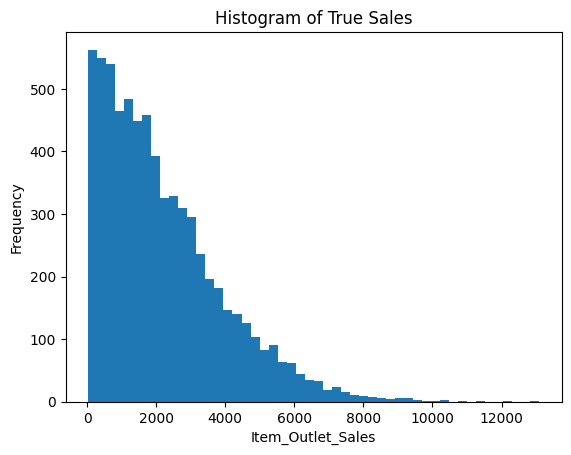

In [117]:


plt.figure()
plt.hist(y_train, bins=50)
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Frequency")
plt.title("Histogram of True Sales")
plt.show()

In [118]:
# import numpy as np

# y_train_log = np.log1p(y_train)
# y_test_log = np.log1p(y_test)



Final prediction data prep

In [119]:
# Filter df_all_filtered to get the test split data
df_test_final = df_all_filtered[df_all_filtered['split'] == 'test'].copy()

# Prepare features for prediction, similar to how X_train was created
# Drop 'Item_Outlet_Sales' (since it's all 0 for test), 'Item_Identifier', 'Outlet_Identifier', and 'split'
X_final_test = df_test_final.copy()
X_final_test["Outlet_ID_TE"] = X_final_test["Outlet_Identifier"].map(outlet_mean)
X_final_test = X_final_test.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier', 'split'])

# Ensure the columns are in the same order as X_train
X_final_test = X_final_test[X_train.columns] # Use X_train.columns to match order and selected features




# Apply the SAME scaler fitted on X_train to the 'Item_Weight' and 'Item_MRP' of the test data
X_final_test[['Item_Weight']] = scaler.transform(X_final_test[['Item_Weight']])

print(f"Shape of final test features for prediction: {X_final_test.shape}")
display(X_final_test.head())


# '','MRP_x_OutletType,'MRP_squared',,'Item_MRP'

Shape of final test features for prediction: (5681, 14)


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC
8523,1.688556,1.029192,27,1550,2337.653479,107.8622,2348.354635,0,1,0,0,0,1,0
8524,-0.991712,1.130311,19,1543,2370.972871,87.3198,2340.675263,0,1,0,0,0,1,0
8525,0.364569,1.735215,28,925,371.726653,241.7538,339.351662,1,0,0,0,0,0,1
8526,-1.203765,1.291577,19,1543,2370.972871,155.0340,2340.675263,0,1,0,0,0,1,0
8527,0.149286,0.917824,41,1559,3776.820790,234.2300,3694.038558,0,0,0,1,0,1,0


In [120]:
X_final_test.columns

Index(['Item_Weight', 'Visibility_Ratio', 'Outlet_Age', 'Outlet_Item_Count',
       'Item_cat_Avg_Sales_Per_Outlet', 'Item_MRP', 'Outlet_Average_Sales',
       'Outlet_Type_cleaned_grocerystore',
       'Outlet_Type_cleaned_supermarkettype1',
       'Outlet_Type_cleaned_supermarkettype2',
       'Outlet_Type_cleaned_supermarkettype3', 'item_category_DR',
       'item_category_FD', 'item_category_NC'],
      dtype='object')

RF Model

In [121]:
# threshold = y_train.quantile(0.75)

# weights = np.where(y_train > threshold, 2, 1)

# weights = 1 + (y_train / y_train.mean())


In [122]:
# residuals = np.abs(y_train - rf_model.predict(X_train))

# weights = 1 + (residuals / residuals.mean())

# weights = weights / np.mean(weights)

In [123]:


# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(
    n_estimators=177,
    max_depth=6,
    min_samples_leaf=7,
    max_features= 0.7785524356036123,
    random_state=71
)

# Train the model
rf_model.fit(X_train, y_train)
# rf_model.fit(X_train, y_train, sample_weight=weights)
# rf_model.fit(X_train, y_train_capped)

print("Random Forest model training complete on scaled data.")






    # n_estimators=100,             # Number of trees in the forest
    # random_state=42,              # Random seed for reproducibility
    # max_depth=10,                 # Maximum depth of the tree
    # min_samples_leaf=5            # Minimum number of samples required to be at a leaf node

Random Forest model training complete on scaled data.


In [124]:
# import lightgbm as lgb

# model = lgb.LGBMRegressor(
#     objective="quantile",
#     alpha=0.5,   # 0.5 = median
#     n_estimators=2000,
#     learning_rate=0.01,
#     random_state=56
# )

# model = lgb.LGBMRegressor(
#     objective="tweedie",
#     tweedie_variance_power=1.2
# )

# model = lgb.LGBMRegressor(
#     objective="regression",   # default MSE
#     n_estimators=2000,
#     learning_rate=0.01
# )

# # model.fit(X_train, y_train)
# model.fit(X_train, y_train_log)



# lgb_model = lgb.LGBMRegressor(
#     objective="regression",
#     n_estimators=3000,
#     learning_rate=0.01,
#     num_leaves=40,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )

# lgb_model.fit(X_train, y_train)



In [125]:
# rf_model=model

In [126]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
# y_pred_rf = model.predict(X_test)

# y_pred_log = model.predict(X_test)
# y_pred_rf = np.expm1(y_pred_log)

# Evaluate the model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# rmse_rf = np.sqrt(mean_squared_error(y_test_capped, y_pred_rf))
# r2_rf = r2_score(y_test_capped, y_pred_rf)

print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf:.2f}")
print(f"R-squared (R2 Score) for Random Forest: {r2_rf:.2f}")

Root Mean Squared Error (RMSE) for Random Forest: 1015.05
R-squared (R2 Score) for Random Forest: 0.62


In [127]:
# # for  ensemble model

# pred_lgb = lgb_model.predict(X_test)
# pred_rf = rf_model.predict(X_test)
# final_pred = 0.2 * pred_lgb + 0.8 * pred_rf

# rmse = np.sqrt(mean_squared_error(y_test, final_pred))
# print("Ensemble RMSE:", rmse)

In [128]:
model=rf_model
y_pred=y_pred_rf


,Feature,Importance
5,Item_MRP,0.553420
6,Outlet_Average_Sales,0.123818
3,Outlet_Item_Count,0.111612
4,Item_cat_Avg_Sales_Per_Outlet,0.103009
7,Outlet_Type_cleaned_grocerystore,0.042725
2,Outlet_Age,0.027766
10,Outlet_Type_cleaned_supermarkettype3,0.023620
0,Item_Weight,0.007863
1,Visibility_Ratio,0.005063
9,Outlet_Type_cleaned_supermarkettype2,0.000318


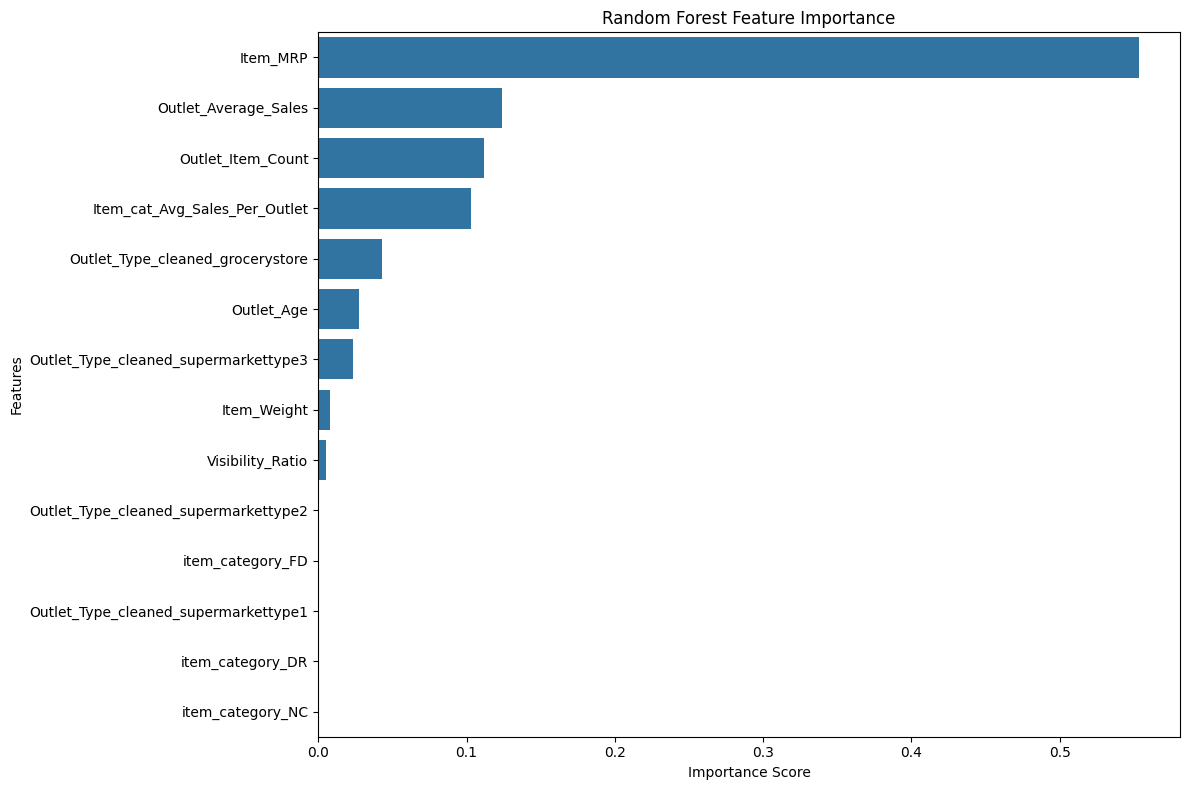

In [129]:


# Get feature importances from Random Forest model
importance_rf = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_names = X_train.columns
df_feature_importance_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_rf
}).sort_values(by='Importance', ascending=False)

# Display top N features
display(df_feature_importance_rf.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_feature_importance_rf.head(20))
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [130]:
# Make predictions on the prepared final test set using the Random Forest model
test_predictions_rf = rf_model.predict(X_final_test)

print("Predictions for the test dataset using Random Forest model:")
display(pd.Series(test_predictions_rf).head())

Predictions for the test dataset using Random Forest model:


,0
0,1682.477141
1,1415.377816
2,573.451260
3,2504.883467
4,6478.838872


In [131]:
# Create a DataFrame for the final predictions with identifiers using Random Forest predictions
submission_df_rf = pd.DataFrame({
    'Item_Identifier': df_test_final['Item_Identifier'],
    'Outlet_Identifier': df_test_final['Outlet_Identifier'],
    'Item_Outlet_Sales': test_predictions_rf
})

display(submission_df_rf.head())

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
8523,FDW58,OUT049,1682.477141
8524,FDW14,OUT017,1415.377816
8525,NCN55,OUT010,573.451260
8526,FDQ58,OUT017,2504.883467
8527,FDY38,OUT027,6478.838872


In [132]:
negative_predictions_count_rf = (test_predictions_rf < 0).sum()
print(f"Number of negative predicted Item_Outlet_Sales values by Random Forest: {negative_predictions_count_rf}")

if negative_predictions_count_rf > 0:
    print("There are negative predicted values. Consider post-processing or a different model objective if sales cannot be negative.")
else:
    print("All predicted values by Random Forest are non-negative.")

Number of negative predicted Item_Outlet_Sales values by Random Forest: 0
All predicted values by Random Forest are non-negative.


In [133]:
submission_df_rf.to_csv('submission_random_forest_3.csv', index=False)
print("submission_random_forest.csv has been saved.")

submission_random_forest.csv has been saved.


#HyperParameter Tuning

In [134]:
import optuna
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    max_features = trial.suggest_float('max_features', 0.6, 1.0) # Changed to suggest_float

    # Initialize Random Forest Regressor with suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=42,
        n_jobs=-1 # Use all available cores
    )

    # Use KFold for cross-validation to get a robust evaluation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X_train))

    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index] # Use raw y_train

        model.fit(X_train_fold, y_train_fold)
        fold_preds = model.predict(X_val_fold)
        oof_preds[val_index] = np.clip(fold_preds, a_min=0, a_max=None) # Clip predictions to be non-negative

    # Calculate RMSE directly on the original scale
    rmse = np.sqrt(mean_squared_error(y_train, oof_preds))

    return rmse

print("Objective function for Optuna defined, using raw target values and clipping predictions.")

Objective function for Optuna defined, using raw target values and clipping predictions.


In [135]:
study = optuna.create_study(direction='minimize') # Minimize RMSE
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Optimization finished.")
print("Best trial:")
print(f"  Value: {study.best_value:.2f} (RMSE)")
print("  Params: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

[I 2026-02-23 11:56:58,285] A new study created in memory with name: no-name-05871c37-ef0d-4ab8-bee5-197fbd64efa0


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-23 11:57:20,388] Trial 0 finished with value: 1116.5014251785858 and parameters: {'n_estimators': 233, 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 14, 'max_features': 0.9348448683865452}. Best is trial 0 with value: 1116.5014251785858.
[I 2026-02-23 11:57:42,989] Trial 1 finished with value: 1096.2636443016759 and parameters: {'n_estimators': 723, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 16, 'max_features': 0.9452595232469468}. Best is trial 1 with value: 1096.2636443016759.
[I 2026-02-23 11:58:14,233] Trial 2 finished with value: 1112.8696665277034 and parameters: {'n_estimators': 793, 'max_depth': 18, 'min_samples_leaf': 9, 'min_samples_split': 20, 'max_features': 0.7946717701910675}. Best is trial 1 with value: 1096.2636443016759.
[I 2026-02-23 11:58:48,906] Trial 3 finished with value: 1113.1874387973537 and parameters: {'n_estimators': 861, 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 20, 'max_features': 0.847676678855

#Error Analysis

In [136]:

# generating val data for  error analysis

df_results = X_test.copy()

# Get Item_Identifier and Outlet_Identifier for the test set
df_results['Item_Identifier'] = df_train_only.loc[X_test.index, 'Item_Identifier']
df_results['Outlet_Identifier'] = df_train_only.loc[X_test.index, 'Outlet_Identifier']

df_results['Actual_Item_Outlet_Sales'] = y_test
df_results['Predicted_Item_Outlet_Sales_RF'] = y_pred_rf

print("Combined DataFrame 'df_results' created with actual and predicted sales, including identifiers.")
display(df_results.head())

Combined DataFrame 'df_results' created with actual and predicted sales, including identifiers.


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC,Item_Identifier,Outlet_Identifier,Actual_Item_Outlet_Sales,Predicted_Item_Outlet_Sales_RF
7503,0.299984,0.928859,39,1553,2326.618577,79.4302,2298.995256,0,1,0,0,0,1,0,FDI28,OUT013,1743.0644,1244.461785
2957,-1.071366,0.929633,29,1550,2178.177575,42.7086,2277.844267,0,1,0,0,0,0,1,NCM17,OUT046,356.8688,702.408132
7031,0.343040,0.960444,27,1550,2337.653479,42.0454,2348.354635,0,1,0,0,0,1,0,FDC14,OUT049,377.5086,707.561795
1084,0.020117,0.953860,41,1559,3294.133992,173.7054,3694.038558,0,0,0,1,1,0,0,DRC36,OUT027,5778.4782,4795.446841
856,-0.583751,0.922116,22,1550,2454.513189,197.5110,2438.841866,0,1,0,0,0,1,0,FDS27,OUT035,2356.9320,3222.688570


In [137]:
# df_results.to_csv('df_results_test.csv', index=False)

In [138]:


@contextmanager
def time_block(step_name, timings, verbose=True):
    if verbose:
        print(f"\n[START] {step_name}")

    start = time.perf_counter()
    yield
    end = time.perf_counter()

    elapsed = round(end - start, 3)
    timings[step_name] = elapsed

    if verbose:
        print(f"[DONE ] {step_name} — {elapsed} sec")


Measurements

In [139]:



# =========================================================
# 1. BASIC ERROR METRICS
# =========================================================

# def compute_errors(y_true, y_pred):
#     df = pd.DataFrame({
#         "y_true": y_true,
#         "y_pred": y_pred
#     })
#     df["error"] = df["y_true"] - df["y_pred"]
#     df["abs_error"] = df["error"].abs()
#     df["sq_error"] = df["error"] ** 2
#     df["pct_error"] = df["abs_error"] / (df["y_true"].abs() + 1e-6)
#     return df

def compute_errors(df, y_true_col, y_pred_col):
    df_err = df.copy()

    df_err["error"] = df_err[y_true_col] - df_err[y_pred_col]
    df_err["abs_error"] = df_err["error"].abs()
    df_err["sq_error"] = df_err["error"] ** 2
    df_err["pct_error"] = (
        df_err["abs_error"] / (df_err[y_true_col].abs() + 1e-6)
    )

    return df_err



def global_error_summary(df_err):
    return {
        "mae": float(df_err["abs_error"].mean()),
        "rmse": float(np.sqrt(df_err["sq_error"].mean())),
        "median_abs_error": float(df_err["abs_error"].median()),
        "mean_error": float(df_err["error"].mean()),
        "error_std": float(df_err["error"].std())
    }


# =========================================================
# 2. ERROR vs TARGET ANALYSIS
# =========================================================

def error_vs_target_analysis(df_err):
    corr_abs = df_err["abs_error"].corr(df_err["y_true"])
    corr_pct = df_err["pct_error"].corr(df_err["y_true"])

    if corr_abs > 0.3:
        pattern = "errors_grow_with_target"
    elif corr_pct < -0.3:
        pattern = "errors_high_for_small_values"
    else:
        pattern = "no_clear_target_pattern"

    return {
        "corr_abs_error_vs_target": float(corr_abs),
        "corr_pct_error_vs_target": float(corr_pct),
        "pattern_hint": pattern
    }


# =========================================================
# 3. ERROR vs FEATURE (CLASSICAL)
# =========================================================

def feature_error_correlations(X, df_err):
    rows = []
    for col in X.columns:
        if np.issubdtype(X[col].dtype, np.number):
            corr = X[col].corr(df_err["abs_error"])
            rows.append({
                "feature": col,
                "abs_error_corr": corr
            })
    return (
        pd.DataFrame(rows)
        .sort_values("abs_error_corr", ascending=False)
        .reset_index(drop=True)
    )


def error_binned_by_feature(X, df_err, feature, bins=5):
    df = pd.concat([X[[feature]], df_err], axis=1).dropna()
    df["bin"] = pd.qcut(df[feature], bins, duplicates="drop")
    return df.groupby("bin")["abs_error"].mean().reset_index()


# =========================================================
# 4. WORST CASES
# =========================================================

def get_worst_cases(X, df_err, top_n=20):
    df = pd.concat([X, df_err], axis=1)
    return df.sort_values("abs_error", ascending=False).head(top_n)


# =========================================================
# 5. PDP (GLOBAL BEHAVIOR)
# =========================================================

def compute_pdp(model, X, feature, grid_points=20):
    """
    Version-safe PDP computation for sklearn >=1.0
    """
    pdp = partial_dependence(
        model,
        X,
        [feature],
        grid_resolution=grid_points,
        kind="average"
    )

    # sklearn >= 1.2 returns Bunch
    if hasattr(pdp, "grid_values"):
        grid = pdp.grid_values[0]
        values = pdp.average[0]
    else:
        # fallback for older versions
        grid = pdp["values"][0]
        values = pdp["average"][0]

    return pd.DataFrame({
        "feature": feature,
        "grid_value": grid,
        "pdp_value": values
    })



def summarize_pdp(pdp_df):
    vals = pdp_df["pdp_value"].values

    slope = np.mean(np.diff(vals))
    curvature = np.mean(np.diff(np.diff(vals)))
    pd_range = vals.max() - vals.min()

    if np.all(np.diff(vals) > 0):
        shape = "monotonic_increasing"
    elif np.all(np.diff(vals) < 0):
        shape = "monotonic_decreasing"
    else:
        shape = "non_monotonic"

    return {
        "pd_range": float(pd_range),
        "mean_slope": float(slope),
        "curvature": float(curvature),
        "shape": shape
    }


# =========================================================
# 6. SHAP VALUES
# =========================================================

def compute_shap_values(model, X, max_samples=5000):
    if X.shape[0] > max_samples:
        X_sample = X.sample(max_samples, random_state=42)
    else:
        X_sample = X.copy()

    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
    except Exception:
        explainer = shap.KernelExplainer(
            model.predict, shap.sample(X_sample, 100)
        )
        shap_values = explainer.shap_values(X_sample, nsamples=100)

    shap_df = pd.DataFrame(
        shap_values,
        columns=X_sample.columns,
        index=X_sample.index
    )

    return shap_df, X_sample


# =========================================================
# 7. SHAP vs ERROR (CORE)
# =========================================================

def shap_error_correlations(shap_df, df_err):
    rows = []
    for col in shap_df.columns:
        corr = shap_df[col].abs().corr(
            df_err.loc[shap_df.index, "abs_error"]
        )
        rows.append({
            "feature": col,
            "shap_abs_error_corr": corr
        })
    return (
        pd.DataFrame(rows)
        .sort_values("shap_abs_error_corr", ascending=False)
        .reset_index(drop=True)
    )


def shap_strength_vs_error(shap_df, df_err):
    shap_strength = shap_df.abs().sum(axis=1)
    return pd.DataFrame({
        "shap_strength": shap_strength,
        "abs_error": df_err.loc[shap_strength.index, "abs_error"]
    })


# =========================================================
# 8. SHAP DEPENDENCE (ERROR-AWARE, NUMERICAL)
# =========================================================

def shap_dependence_error_summary(shap_df, X, df_err, feature, bins=6):
    """
    Numerical summary of SHAP dependence colored by error.
    """
    df = pd.concat([
        X[[feature]].rename(columns={feature: "feature_value"}),
        shap_df[[feature]].rename(columns={feature: "shap_value"}),
        df_err[["abs_error"]]
    ], axis=1).dropna()

    # IMPORTANT: pass a Series, not DataFrame
    df["feature_bin"] = pd.qcut(
        df["feature_value"],
        bins,
        duplicates="drop"
    )

    return (
        df.groupby("feature_bin")
        .agg(
            mean_feature_value=("feature_value", "mean"),
            mean_shap_value=("shap_value", "mean"),
            mean_abs_error=("abs_error", "mean")
        )
        .reset_index()
    )



# =========================================================
# 9. SHAP SUMMARY vs ERROR BUCKETS
# =========================================================

def shap_summary_by_error_bucket(shap_df, df_err, n_buckets=4):
    df = shap_df.copy()
    df["abs_error"] = df_err.loc[shap_df.index, "abs_error"]

    df["error_bucket"] = pd.qcut(
        df["abs_error"],
        n_buckets,
        labels=[f"bucket_{i+1}" for i in range(n_buckets)]
    )

    return (
        df.groupby("error_bucket")
        .mean()
        .abs()
        .T
    )


# =========================================================
# 10. SHAP INTERACTION vs ERROR
# =========================================================

def shap_interaction_vs_error(model, X, df_err, top_features, max_samples=2000):
    if X.shape[0] > max_samples:
        X_sample = X.sample(max_samples, random_state=42)
    else:
        X_sample = X.copy()

    explainer = shap.TreeExplainer(model)
    interaction_vals = explainer.shap_interaction_values(X_sample)

    results = []

    for i, f1 in enumerate(top_features):
        for j, f2 in enumerate(top_features):
            if j <= i:
                continue

            interaction_strength = np.abs(interaction_vals[:, i, j])
            corr = np.corrcoef(
                interaction_strength,
                df_err.loc[X_sample.index, "abs_error"]
            )[0, 1]

            results.append({
                "feature_1": f1,
                "feature_2": f2,
                "interaction_error_corr": corr
            })

    return (
        pd.DataFrame(results)
        .sort_values("interaction_error_corr", ascending=False)
        .reset_index(drop=True)
    )

###DATA FRAME OUTPUT#####

def build_dataframe_outputs(results):
    """
    Convert all important outputs into pandas DataFrames
    for inspection, export, and future LLM usage.
    """
    dfs = {}

    # ---------------- Core error table ----------------
    dfs["errors"] = results["df_errors"].copy()

    # ---------------- Feature error correlations ----------------
    dfs["feature_error_correlations"] = (
        results["feature_error_correlations"].copy()
    )

    # ---------------- Worst cases ----------------
    dfs["worst_cases"] = results["worst_cases"].copy()

    # ---------------- PDP raw (stacked) ----------------
    pdp_rows = []
    for feat, df in results["pdp_raw"].items():
        tmp = df.copy()
        tmp["feature"] = feat
        pdp_rows.append(tmp)

    if pdp_rows:
        dfs["pdp_raw"] = pd.concat(pdp_rows, ignore_index=True)
    else:
        dfs["pdp_raw"] = pd.DataFrame()

    # ---------------- PDP summary ----------------
    dfs["pdp_summary"] = (
        pd.DataFrame(results["pdp_summary"])
        .T
        .reset_index()
        .rename(columns={"index": "feature"})
    )

    # ---------------- SHAP values ----------------
    dfs["shap_values"] = results["shap_values"].copy()

    # ---------------- SHAP vs error correlation ----------------
    dfs["shap_error_correlations"] = (
        results["shap_error_correlations"].copy()
    )

    # ---------------- SHAP strength vs error ----------------
    dfs["shap_strength_vs_error"] = (
        results["shap_strength_vs_error"].copy()
    )

    # ---------------- SHAP dependence summaries ----------------
    dep_rows = []
    for feat, df in results["shap_dependence_summaries"].items():
        tmp = df.copy()
        tmp["feature"] = feat
        dep_rows.append(tmp)

    if dep_rows:
        dfs["shap_dependence_summary"] = pd.concat(
            dep_rows, ignore_index=True
        )
    else:
        dfs["shap_dependence_summary"] = pd.DataFrame()

    # ---------------- SHAP error buckets ----------------
    dfs["shap_error_buckets"] = (
        results["shap_error_buckets"]
        .reset_index()
        .rename(columns={"index": "feature"})
    )

    # ---------------- SHAP interaction vs error ----------------
    dfs["shap_interaction_error"] = (
        results["shap_interaction_error_corr"].copy()
    )

    # ---------------- Timings ----------------
    dfs["timings"] = (
        pd.DataFrame.from_dict(
            results["timings"], orient="index", columns=["seconds"]
        )
        .reset_index()
        .rename(columns={"index": "step"})
    )

    return dfs


# =========================================================
# 11. MASTER PIPELINE (STEP-1 ONLY)
# =========================================================



def run_error_analysis_regression(
    model,
    X,
    y_true,
    y_pred,
    pdp_top_k=2,
    shap_top_k=2
):
    timings = {}

    # with time_block("01_compute_errors", timings):
    #     df_err = compute_errors(y_true, y_pred)


    with time_block("01_compute_errors", timings):
      df_base = X.copy()
      df_base["y_true"] = y_true
      df_base["y_pred"] = y_pred

      df_err = compute_errors(
          df_base,
          y_true_col="y_true",
          y_pred_col="y_pred"
      )

    with time_block("02_global_error_summary", timings):
        global_summary = global_error_summary(df_err)

    with time_block("03_error_vs_target_analysis", timings):
        target_analysis = error_vs_target_analysis(df_err)

    with time_block("04_feature_error_correlations", timings):
        feature_corr_df = feature_error_correlations(X, df_err)

    with time_block("05_worst_cases", timings):
        worst_cases = get_worst_cases(X, df_err)

    # ---------------- PDP ----------------
    pdp_raw = {}
    pdp_summary = {}

    top_pdp_features = feature_corr_df.head(pdp_top_k)["feature"]

    with time_block("06_PDP_computation", timings):
        for feat in top_pdp_features:
            pdp_df = compute_pdp(model, X, feat)
            pdp_raw[feat] = pdp_df
            pdp_summary[feat] = summarize_pdp(pdp_df)

    # ---------------- SHAP ----------------
    with time_block("07_SHAP_values", timings):
        shap_df, X_shap = compute_shap_values(model, X)

    with time_block("08_SHAP_error_correlations", timings):
        shap_error_corr = shap_error_correlations(shap_df, df_err)

    with time_block("09_SHAP_strength_vs_error", timings):
        shap_strength_df = shap_strength_vs_error(shap_df, df_err)

    top_shap_features = shap_error_corr.head(shap_top_k)["feature"].tolist()

    with time_block("10_SHAP_dependence_error_summary", timings):
        shap_dependence_summaries = {
            feat: shap_dependence_error_summary(
                shap_df, X_shap, df_err, feat
            )
            for feat in top_shap_features
        }

    with time_block("11_SHAP_error_buckets", timings):
        shap_error_buckets = shap_summary_by_error_bucket(
            shap_df, df_err
        )

    with time_block("12_SHAP_interaction_vs_error", timings):
        shap_interactions = shap_interaction_vs_error(
            model, X, df_err, top_shap_features
        )

    with time_block("13_LLM_ready_summary_build", timings):
        llm_ready_summary = {
            "global_error_summary": global_summary,
            "target_error_analysis": target_analysis,
            "top_error_features": (
                feature_corr_df
                .head(10)
                .set_index("feature")["abs_error_corr"]
                .to_dict()
            ),
            "pdp_summary": pdp_summary,
            "shap_error_associations": (
                shap_error_corr
                .head(10)
                .set_index("feature")["shap_abs_error_corr"]
                .to_dict()
            ),
            "shap_interaction_error_signals": (
                shap_interactions.head(10).to_dict(orient="records")
            ),
            "shap_dependence_error_ranges": {
                k: v.to_dict(orient="records")
                for k, v in shap_dependence_summaries.items()
            },
            "shap_importance_by_error_bucket": (
                shap_error_buckets.iloc[:10].to_dict()
            )
        }

    timings["TOTAL_RUNTIME"] = round(sum(timings.values()), 3)

    # return {
    #     "df_errors": df_err,
    #     "feature_error_correlations": feature_corr_df,
    #     "worst_cases": worst_cases,
    #     "pdp_raw": pdp_raw,
    #     "pdp_summary": pdp_summary,
    #     "shap_values": shap_df,
    #     "shap_error_correlations": shap_error_corr,
    #     "shap_strength_vs_error": shap_strength_df,
    #     "shap_dependence_summaries": shap_dependence_summaries,
    #     "shap_error_buckets": shap_error_buckets,
    #     "shap_interaction_error_corr": shap_interactions,
    #     "llm_ready_summary": llm_ready_summary,
    #     "timings": timings
    # }

    results = {
    "df_errors": df_err,
    "global_summary": global_summary,
    "target_analysis": target_analysis,
    "feature_error_correlations": feature_corr_df,
    "worst_cases": worst_cases,
    "pdp_raw": pdp_raw,
    "pdp_summary": pdp_summary,
    "shap_values": shap_df,
    "shap_error_correlations": shap_error_corr,
    "shap_strength_vs_error": shap_strength_df,
    "shap_dependence_summaries": shap_dependence_summaries,
    "shap_error_buckets": shap_error_buckets,
    "shap_interaction_error_corr": shap_interactions,
    "llm_ready_summary": llm_ready_summary,
    "timings": timings
       }

    results["outputs_as_dataframes"] = build_dataframe_outputs(results)
    return results



In [140]:
results = run_error_analysis_regression(
    model=model,
    X=X_test,
    y_true=y_test,
    y_pred=y_pred,
    pdp_top_k=2,
    shap_top_k=2
)



[START] 01_compute_errors
[DONE ] 01_compute_errors — 0.004 sec

[START] 02_global_error_summary
[DONE ] 02_global_error_summary — 0.0 sec

[START] 03_error_vs_target_analysis
[DONE ] 03_error_vs_target_analysis — 0.0 sec

[START] 04_feature_error_correlations
[DONE ] 04_feature_error_correlations — 0.004 sec

[START] 05_worst_cases
[DONE ] 05_worst_cases — 0.003 sec

[START] 06_PDP_computation
[DONE ] 06_PDP_computation — 0.007 sec

[START] 07_SHAP_values
[DONE ] 07_SHAP_values — 1.794 sec

[START] 08_SHAP_error_correlations
[DONE ] 08_SHAP_error_correlations — 0.007 sec

[START] 09_SHAP_strength_vs_error
[DONE ] 09_SHAP_strength_vs_error — 0.001 sec

[START] 10_SHAP_dependence_error_summary
[DONE ] 10_SHAP_dependence_error_summary — 0.024 sec

[START] 11_SHAP_error_buckets
[DONE ] 11_SHAP_error_buckets — 0.003 sec

[START] 12_SHAP_interaction_vs_error


/tmp/ipython-input-4245601466.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("feature_bin")
/tmp/ipython-input-4245601466.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("feature_bin")
/tmp/ipython-input-4245601466.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("error_bucket")


[DONE ] 12_SHAP_interaction_vs_error — 24.818 sec

[START] 13_LLM_ready_summary_build
[DONE ] 13_LLM_ready_summary_build — 0.003 sec


In [141]:
dfs = results["outputs_as_dataframes"]
dfs.keys()

dict_keys(['errors', 'feature_error_correlations', 'worst_cases', 'pdp_raw', 'pdp_summary', 'shap_values', 'shap_error_correlations', 'shap_strength_vs_error', 'shap_dependence_summary', 'shap_error_buckets', 'shap_interaction_error', 'timings'])

In [142]:
dfs["errors"].head()

,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC,y_true,y_pred,error,abs_error,sq_error,pct_error
7503,0.299984,0.928859,39,1553,2326.618577,79.4302,2298.995256,0,1,0,0,0,1,0,1743.0644,1244.461785,498.602615,498.602615,248604.567561,0.286049
2957,-1.071366,0.929633,29,1550,2178.177575,42.7086,2277.844267,0,1,0,0,0,0,1,356.8688,702.408132,-345.539332,345.539332,119397.429849,0.968253
7031,0.343040,0.960444,27,1550,2337.653479,42.0454,2348.354635,0,1,0,0,0,1,0,377.5086,707.561795,-330.053195,330.053195,108935.111822,0.874293
1084,0.020117,0.953860,41,1559,3294.133992,173.7054,3694.038558,0,0,0,1,1,0,0,5778.4782,4795.446841,983.031359,983.031359,966350.653305,0.170119
856,-0.583751,0.922116,22,1550,2454.513189,197.5110,2438.841866,0,1,0,0,0,1,0,2356.9320,3222.688570,-865.756570,865.756570,749534.438429,0.367324


In [143]:
df_err=dfs["errors"].copy()

2.TARGET SPACE DIAGNOSIS

In [144]:
# identify outliers/lossdominance/instability

def diagnose_error_extremes_df(
    df_err,
    z_thresh=2.5,
    top_frac=0.01,
    dominance_thresh=0.3
):
    """
    Row-level diagnostics added directly to df_err.

    df_err must already contain:
    - features
    - y_true, y_pred
    - error, abs_error, sq_error, pct_error
    """

    df = df_err.copy()

    # --------------------------------------------------
    # 1. OUTLIERS (rarity via absolute error)
    # --------------------------------------------------
    mu = df["abs_error"].mean()
    sigma = df["abs_error"].std() + 1e-9

    df["abs_error_z"] = (df["abs_error"] - mu) / sigma
    df["is_abs_error_outlier"] = df["abs_error_z"] > z_thresh

    # --------------------------------------------------
    # 2. LOSS DOMINANCE (severity via squared error)
    # --------------------------------------------------
    loss_cutoff = df["sq_error"].quantile(1 - top_frac)
    df["is_loss_dominant"] = df["sq_error"] >= loss_cutoff

    total_loss = df["sq_error"].sum()
    dominant_loss = df.loc[df["is_loss_dominant"], "sq_error"].sum()

    loss_fraction = dominant_loss / (total_loss + 1e-9)

    # --------------------------------------------------
    # 3. OPTIMIZATION INSTABILITY (global signal)
    # --------------------------------------------------
    df["optimization_instability_flag"] = (
        loss_fraction > dominance_thresh
    )

    # --------------------------------------------------
    # 4. Diagnostic tags (human-readable)
    # --------------------------------------------------
    df["diagnostic_tag"] = "normal"

    df.loc[df["is_abs_error_outlier"], "diagnostic_tag"] = "rare_extreme_error"
    df.loc[df["is_loss_dominant"], "diagnostic_tag"] = "loss_dominant_row"

    # --------------------------------------------------
    # 5. Summary dataframe
    # --------------------------------------------------
    diagnostic_summary_df = pd.DataFrame([
        {
            "diagnostic": "abs_error_outliers",
            "threshold": z_thresh,
            "fraction_of_rows": df["is_abs_error_outlier"].mean(),
            "max_abs_error": df["abs_error"].max()
        },
        {
            "diagnostic": "loss_dominance",
            "threshold": top_frac,
            "fraction_of_rows": df["is_loss_dominant"].mean(),
            "loss_fraction": loss_fraction
        },
        {
            "diagnostic": "optimization_instability",
            "threshold": dominance_thresh,
            "flag": loss_fraction > dominance_thresh
        }
    ])

    return df, diagnostic_summary_df


In [145]:
# df_err already contains features + predictions + errors
df_diag, summary = diagnose_error_extremes_df(df_err)

# Inspect problematic rows
df_diag[df_diag["diagnostic_tag"] != "normal"]

# High-level view
summary


,diagnostic,threshold,fraction_of_rows,max_abs_error,loss_fraction,flag
0,abs_error_outliers,2.50,0.029912,5591.983431,NaN,NaN
1,loss_dominance,0.01,0.010557,NaN,0.16782,NaN
2,optimization_instability,0.30,NaN,NaN,NaN,False


In [146]:
# identify high error regions

def diagnose_high_error_regions(df_err, bins=5):
    """
    Identify high-error regions across target value ranges.

    Parameters
    ----------
    df_err : pd.DataFrame
        Must contain 'y_true', 'abs_error', 'pct_error'
    bins : int
        Number of quantile bins

    Returns
    -------
    pd.DataFrame
        Columns:
        - target_bin
        - mean_abs_error
        - mean_mape
        - count
        - error_contribution_pct
    """
    total_abs_error = df_err["abs_error"].sum()

    target_bins = pd.qcut(
        df_err["y_true"],
        bins,
        duplicates="drop"
    )

    target_error_regions_df = (
        df_err
        .assign(target_bin=target_bins)
        .groupby("target_bin", observed=True)
        .agg(
            mean_abs_error=("abs_error", "mean"),
            mean_mape=("pct_error", "mean"),
            count=("abs_error", "size"),
            total_abs_error_bin=("abs_error", "sum")
        )
        .reset_index()
    )

    target_error_regions_df["error_contribution_pct"] = (
        target_error_regions_df["total_abs_error_bin"]
        / (total_abs_error + 1e-9)
    ) * 100

    # optional: drop intermediate column
    target_error_regions_df = target_error_regions_df.drop(
        columns=["total_abs_error_bin"]
    )

    return target_error_regions_df


In [147]:
high_error_df = diagnose_high_error_regions(df_err)

high_error_df


,target_bin,mean_abs_error,mean_mape,count,error_contribution_pct
0,"(33.289, 615.066]",369.950088,1.251548,341,10.435422
1,"(615.066, 1341.986]",623.881622,0.656545,341,17.598233
2,"(1341.986, 2184.49]",660.554256,0.392077,342,18.687323
3,"(2184.49, 3343.248]",621.154463,0.229935,340,17.469924
4,"(3343.248, 10236.675]",1269.481907,0.257331,341,35.809098


In [148]:
def run_target_space_error_diagnostics(
    df_err,
    target_bins=5,
    z_thresh=2.5,
    top_frac=0.01,
    dominance_thresh=0.3
):
    """
    Target-space error diagnostics module.

    Focuses ONLY on issues related to:
    - target scale
    - high-error regions
    - outliers
    - loss dominance
    - optimization instability

    Parameters
    ----------
    df_err : pd.DataFrame
        Must contain y_true, y_pred, error metrics
    target_bins : int
        Number of bins for target-space analysis
    z_thresh : float
        Z-score threshold for abs-error outliers
    top_frac : float
        Fraction of rows considered loss-dominant
    dominance_thresh : float
        Loss fraction threshold for instability

    Returns
    -------
    dict of DataFrames
    """

    outputs = {}

    # --------------------------------------------------
    # 1. High-error regions in target space
    # --------------------------------------------------
    high_error_regions_df = diagnose_high_error_regions(
        df_err,
        bins=target_bins
    )

    outputs["target_high_error_regions"] = high_error_regions_df

    # --------------------------------------------------
    # 2. Outliers, loss dominance, instability (row-level)
    # --------------------------------------------------
    df_extremes, extremes_summary_df = diagnose_error_extremes_df(
        df_err,
        z_thresh=z_thresh,
        top_frac=top_frac,
        dominance_thresh=dominance_thresh
    )

    outputs["target_extreme_rows"] = df_extremes
    outputs["target_extremes_summary"] = extremes_summary_df

    # --------------------------------------------------
    # 3. Compact executive summary (target-space only)
    # --------------------------------------------------
    summary_rows = []

    # High-error region signal
    worst_bin = high_error_regions_df.sort_values(
        "error_contribution_pct", ascending=False
    ).iloc[0]

    summary_rows.append({
        "issue_type": "high_error_target_region",
        "detail": str(worst_bin["target_bin"]),
        "error_contribution_pct": worst_bin["error_contribution_pct"],
        "mean_abs_error": worst_bin["mean_abs_error"],
        "mean_mape": worst_bin["mean_mape"]
    })

    # Outlier signal
    outlier_frac = extremes_summary_df.loc[
        extremes_summary_df["diagnostic"] == "abs_error_outliers",
        "fraction_of_rows"
    ].values[0]

    summary_rows.append({
        "issue_type": "rare_extreme_errors",
        "detail": "abs_error_outliers",
        "fraction_of_rows": outlier_frac
    })

    # Loss dominance / instability
    loss_row = extremes_summary_df.loc[
        extremes_summary_df["diagnostic"] == "loss_dominance"
    ].iloc[0]

    instab_row = extremes_summary_df.loc[
        extremes_summary_df["diagnostic"] == "optimization_instability"
    ].iloc[0]

    summary_rows.append({
        "issue_type": "loss_dominance",
        "detail": f"top_{int(top_frac*100)}pct_rows",
        "loss_fraction": loss_row["loss_fraction"]
    })

    summary_rows.append({
        "issue_type": "optimization_instability",
        "detail": "global",
        "flag": instab_row["flag"]
    })

    outputs["target_space_summary"] = pd.DataFrame(summary_rows)

    return outputs


In [149]:

# Step 2: target-space diagnostics
target_outputs = run_target_space_error_diagnostics(df_err)

# Inspect
target_outputs["target_high_error_regions"]
target_outputs["target_space_summary"]

# Drill down
target_outputs["target_extreme_rows"][
    target_outputs["target_extreme_rows"]["diagnostic_tag"] != "normal"
].head()


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Average_Sales,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,...,y_pred,error,abs_error,sq_error,pct_error,abs_error_z,is_abs_error_outlier,is_loss_dominant,optimization_instability_flag,diagnostic_tag
5990,0.472210,0.917824,41,1559,3776.820790,219.8456,3694.038558,0,0,0,...,5697.985644,-4150.666444,4150.666444,1.722803e+07,2.682489,4.736816,True,True,False,loss_dominant_row
4094,0.343040,0.934891,19,1543,2370.972871,262.7594,2340.675263,0,1,0,...,4152.350566,2912.453234,2912.453234,8.482384e+06,0.412248,3.032632,True,False,False,rare_extreme_error
3590,-0.561146,1.066413,19,1543,2370.972871,191.5530,2340.675263,0,1,0,...,3176.709183,3464.645817,3464.645817,1.200377e+07,0.521678,3.792628,True,True,False,loss_dominant_row
6569,-0.625731,1.059239,39,1553,2326.618577,245.4144,2298.995256,0,1,0,...,4073.559098,3031.858502,3031.858502,9.192166e+06,0.426697,3.196972,True,False,False,rare_extreme_error
3541,0.149286,1.033590,19,1543,2370.972871,157.0946,2340.675263,0,1,0,...,2616.725560,2906.085440,2906.085440,8.445333e+06,0.526197,3.023867,True,False,False,rare_extreme_error


In [150]:
# target_outputs["target_extreme_rows"].to_csv('extreme_rows.csv', index=False)

# submission_df_rf


In [151]:
# Feature transformation diagnostics-numerical

def diagnose_feature_transformations(X, df_err, features, bins=6):
    rows = []

    for feat in features:
        df = pd.concat(
            [X[[feat]], df_err[["abs_error"]]],
            axis=1
        ).dropna()

        df["bin"] = pd.qcut(df[feat], bins, duplicates="drop")
        stats = df.groupby("bin", observed=True)["abs_error"].agg(["mean", "std"])

        rows.append({
            "feature": feat,
            "error_range": stats["mean"].max() - stats["mean"].min(),
            "error_std_ratio": stats["std"].max() / (stats["std"].min() + 1e-6)
        })

    return (
        pd.DataFrame(rows)
        .sort_values("error_range", ascending=False)
        .reset_index(drop=True)
    )


# feature inertaction diagnostics

def diagnose_feature_interactions(shap_interaction_error_df, top_k=10):
    return (
        shap_interaction_error_df
        .head(top_k)
        .reset_index(drop=True)
    )


# feature removal  diagnostics
def diagnose_feature_removal(
    shap_df,
    shap_error_corr_df,
    pdp_summary,
    shap_thresh=0.01,
    error_corr_thresh=0.05
):
    rows = []

    for feat in shap_df.columns:
        mean_shap = shap_df[feat].abs().mean()

        err_corr = shap_error_corr_df.loc[
            shap_error_corr_df["feature"] == feat,
            "shap_abs_error_corr"
        ].values[0]

        pdp_shape = pdp_summary.get(feat, {}).get("shape", "unknown")

        rows.append({
            "feature": feat,
            "mean_abs_shap": mean_shap,
            "shap_error_corr": err_corr,
            "pdp_shape": pdp_shape,
            "removal_candidate": (
                mean_shap < shap_thresh
                and abs(err_corr) < error_corr_thresh
            )
        })

    return (
        pd.DataFrame(rows)
        .sort_values("mean_abs_shap")
        .reset_index(drop=True)
    )


# feature subpopulation diagnostics

def diagnose_feature_subpopulations(X, df_err, feature, bins=5):
    df = pd.concat(
        [X[[feature]], df_err[["abs_error"]]],
        axis=1
    ).dropna()

    df["bin"] = pd.qcut(df[feature], bins, duplicates="drop")

    return (
        df.groupby("bin", observed=True)
        .agg(
            mean_abs_error=("abs_error", "mean"),
            count=("abs_error", "size")
        )
        .reset_index()
    )
# extrapolation diagnostics

# distance calculation
from sklearn.neighbors import NearestNeighbors

def compute_data_coverage_distance(X_train, X_test, k=5):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X_train)

    distances, _ = nn.kneighbors(X_test)
    return distances.mean(axis=1)


# extrapolation vs error

def diagnose_extrapolation(df_err, coverage_distances, quantile=0.95):
    df = df_err.copy()
    df["coverage_distance"] = coverage_distances

    threshold = np.quantile(coverage_distances, quantile)
    df["is_extrapolation"] = df["coverage_distance"] > threshold

    summary = (
        df.groupby("is_extrapolation")
        .agg(
            mean_abs_error=("abs_error", "mean"),
            count=("abs_error", "size")
        )
        .reset_index()
    )

    return df, summary


In [152]:
def run_feature_space_diagnostics(
    X_train,
    X_test,
    df_err,
    shap_df,
    shap_error_corr_df,
    shap_interaction_error_df,
    pdp_summary,
    top_features,
    bins=6
):
    outputs = {}

    # 1. Transformations
    outputs["feature_transformation_signals"] = (
        diagnose_feature_transformations(
            X_test, df_err, top_features, bins
        )
    )

    # 2. Interactions
    outputs["feature_interaction_signals"] = (
        diagnose_feature_interactions(
            shap_interaction_error_df
        )
    )

    # 3. Removal candidates
    outputs["feature_removal_signals"] = (
        diagnose_feature_removal(
            shap_df,
            shap_error_corr_df,
            pdp_summary
        )
    )

    # 4. Subpopulations
    outputs["feature_subpopulation_signals"] = {
        feat: diagnose_feature_subpopulations(
            X_test, df_err, feat
        )
        for feat in top_features
    }

    # 5. Data coverage / extrapolation
    coverage_dist = compute_data_coverage_distance(
        X_train, X_test
    )

    extrap_df, extrap_summary = diagnose_extrapolation(
        df_err, coverage_dist
    )

    outputs["data_coverage_rows"] = extrap_df
    outputs["data_coverage_summary"] = extrap_summary

    return outputs


In [153]:
top_features = dfs['shap_error_correlations'].head(20)['feature'].tolist()

feature_outputs = run_feature_space_diagnostics(
    X_train=X_train,
    X_test=X_test,
    df_err=df_err,
    shap_df=dfs['shap_values'],
    shap_error_corr_df=dfs['shap_error_correlations'],
    shap_interaction_error_df=dfs['shap_interaction_error'],
    pdp_summary=results['pdp_summary'],
    top_features=top_features,
    bins=6
)


In [154]:
feature_outputs.keys()

dict_keys(['feature_transformation_signals', 'feature_interaction_signals', 'feature_removal_signals', 'feature_subpopulation_signals', 'data_coverage_rows', 'data_coverage_summary'])

In [155]:
feature_outputs["feature_subpopulation_signals"][top_features[0]]

,bin,mean_abs_error,count
0,"(-0.001, 1.0]",709.027576,1705


In [156]:
feature_outputs['feature_transformation_signals']

,feature,error_range,error_std_ratio
0,Item_MRP,913.655858,4.057287
1,Item_cat_Avg_Sales_Per_Outlet,696.855755,2.001746
2,Outlet_Average_Sales,640.070270,1.628314
3,Outlet_Item_Count,601.328659,1.330427
4,Visibility_Ratio,558.535891,2.201613
5,Outlet_Age,221.547215,1.206064
6,Item_Weight,119.596349,1.216556
7,item_category_DR,0.000000,1.000000
8,Outlet_Type_cleaned_supermarkettype3,0.000000,1.000000
9,item_category_FD,0.000000,1.000000
